# Multiclass kernel SVM - model implemenation

In this notebook, we are training custom implementation of multiclass kernel SVM model. As a result, we will compare the model performace confusion matrix (accuracy and F1-measure) with sklearn model, which will be a benchmark for our test.

### Importing dataset

In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Importing cvxopt library functionalities for solving quadratic problem optimization 
import cvxopt
import cvxopt.solvers
import cvxopt.base

In [3]:
# Importing cleaned dataset with apartments for sale in Belgrade
dataset = pd.read_csv('../../database/backup/belgrade_flats.csv')
dataset.head()

,price,location_city,location_city_district,area_property,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms
0,109000.0,beograd,stari grad,71.0,9.0,7.0,False,Centralno,2.0,1.0
1,149500.0,beograd,stari grad,74.0,4.0,2.0,True,Centralno,3.0,1.0
2,108000.0,beograd,zvezdara,60.0,4.0,3.0,False,Etažno,2.5,1.0
3,145000.0,beograd,vracar,96.0,2.0,1.0,True,Etažno,4.5,1.0
4,180000.0,beograd,palilula,94.0,5.0,4.0,True,Centralno,4.0,1.0


### Preparing data for modeling

In [4]:
def determine_category(price):
    """Returns category based on a price e.g. cheap, affordable, expensive - expressed by ascending numbers category."""
    if price < 50000:
        return 0
    elif price >= 50000 and price < 100000:
        return 1
    elif price >= 100000 and price < 150000:
        return 2
    elif price >= 150000 and price < 200000:
        return 3
    elif price >= 200000:
        return 4

In [5]:
# Creating new column - categories (based on price segment)
dataset['price'] = dataset['price'].apply(determine_category)

In [6]:
# Price segment (category) distribution
dataset['price'].value_counts()

1    1224
2     915
4     667
0     489
3     448
Name: price, dtype: int64

Text(0, 0.5, 'Number of flats')

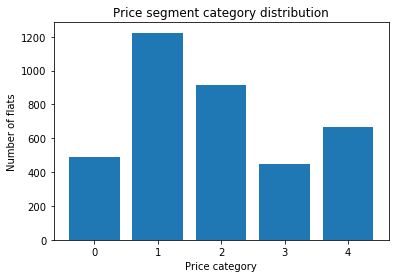

In [7]:
# Visualizing category distribution
plt.bar(dataset['price'].value_counts().index, dataset['price'].value_counts().values)
plt.title('Price segment category distribution')
plt.xlabel('Price category')
plt.ylabel('Number of flats')

In [8]:
# Removing columns that aren't going to be used in classification models
dataset = dataset.drop(columns=['location_city',])
dataset.head()

,price,location_city_district,area_property,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms
0,2,stari grad,71.0,9.0,7.0,False,Centralno,2.0,1.0
1,2,stari grad,74.0,4.0,2.0,True,Centralno,3.0,1.0
2,2,zvezdara,60.0,4.0,3.0,False,Etažno,2.5,1.0
3,2,vracar,96.0,2.0,1.0,True,Etažno,4.5,1.0
4,3,palilula,94.0,5.0,4.0,True,Centralno,4.0,1.0


In [9]:
# Splitting dataset into features (input values) and output value 
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

In [10]:
# Encocding catgorical variables:
# 1. City district/municipality
# 2. Heating type

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), [0, 5])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [11]:
# Splitting dataset into train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.tolist(), y, test_size = 0.2, random_state = 0)

In [12]:
from sklearn.preprocessing import StandardScaler
ct2 = ColumnTransformer([('standard_scaler', StandardScaler(), [-1, -2, -4, -5, -6])], remainder='passthrough')
X_train = ct2.fit_transform(X_train)
X_test = ct2.transform(X_test)

In [13]:
X_train[0]

array([-0.228006556753357, -0.6227066141120254, 0.5433681637956224,
       0.843891177248956, -0.36314601634061805, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, True], dtype=object)

### Training multiclass kernel SVM

In [14]:
# Importing custom implementation of our model
from svm import MulticlassSVM

In [15]:
multi = MulticlassSVM(kernel="rbf", gamma=3)

In [16]:
multi.fit(X_train, y_train)

Provided multiclass output labels. Creating 5 binary classificators...
Fitting one-to-many SVM binary classifier for class: 0
Fitting one-to-many SVM binary classifier for class: 1
Fitting one-to-many SVM binary classifier for class: 2
Fitting one-to-many SVM binary classifier for class: 3
Fitting one-to-many SVM binary classifier for class: 4


### Evaluating our model

In [17]:
y_pred = multi.predict(X_test)

In [18]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[ 45,  22,   8,   3,  15],
       [ 40, 138,  39,   8,  28],
       [ 10,  41,  88,  21,  23],
       [  0,   5,  11,  42,  27],
       [  0,   1,   2,  25, 107]], dtype=int64)

In [19]:
# Calculating accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.5607476635514018

In [20]:
# Calculating macro-F1 measure
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='macro')

0.5411546335831344

In [21]:
# Calculating micro-F1 measure
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='micro')

0.5607476635514018

## Saving the model and the column transformers (onehotencoder and scaler)

#### Serializing and exporting multiclass SVM

In [23]:
import pickle

In [24]:
# Saving the SVM model
with open("model/svm.pickle", "wb") as output:
    pickle.dump(multi, output)

#### Serializing and exporting column transformer - OneHotEncoder

In [26]:
# Saving one-hot-encoder - categorical column encoder
with open("model/onehotencoder.pickle", "wb") as output:
    pickle.dump(ct, output)